#### Imports

In [329]:
# Core imports
from copy import deepcopy

# Installed imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Local imports

In [330]:
def load_demonstrations_file(filename):
    """ Load a .npz file containing a list of demonstrations.
        Returns a list of trajectories, each of which is a tuple containing a
        len_trajectory x num_states state matrix and a len_trajectory x num_controls control matrix. 
    """
    demonstrations = np.load(filename, allow_pickle=True)['demonstrations']
    return demonstrations

def load_centerlines(filename):
    data = np.load(filename)
    return data['lines']

centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

def stack_demonstrations(demonstrations):
    state_matrices = [demonstration[0] for demonstration in demonstrations]
    control_matrices = [demonstration[1] for demonstration in demonstrations]
    return np.vstack(state_matrices), np.vstack(control_matrices)

#### Load train, validation, and test demonstration trajectories 

In [356]:
k_closest_vehicles = 2
k_closest_pedestrians = 0

train_demonstrations = load_demonstrations_file("./Data/Demonstrations/train_demonstrations_k_closest_vehicles=2_k_closest_pedestrians=0.npz")
validation_demonstrations = load_demonstrations_file("./Data/Demonstrations/validation_demonstrations_k_closest_vehicles=2_k_closest_pedestrians=0.npz")
test_demonstrations = load_demonstrations_file("./Data/Demonstrations/test_demonstrations_k_closest_vehicles=2_k_closest_pedestrians=0.npz")

In [357]:
combined_train_state, combined_train_controls = stack_demonstrations(train_demonstrations)
combined_validation_state, combined_validation_controls = stack_demonstrations(validation_demonstrations)

#### Do any pre-processing to the state that we'd like. For instance, here we can turn things into an ego-centric frame.

For now, I'm not going to change into ego-centric just because not sure how to deal with predicting the delta x and y with that. 

In [358]:
x_hat = np.array([1, 2])
y_hat = np.array([3, 4])
R = np.array([x_hat, y_hat])
R

array([[1, 2],
       [3, 4]])

In [361]:
def vehicle_index_to_row(index):
    return 4 + 4*index

def pedestrian_index_to_row(index, k_closest_vehicles):
    return 4 + 4*k_closest_vehicles + 4*index

def road_frame_state(state_matrix, k_closest_vehicles, k_closest_pedestrians):
    """ 
        Create a new state matrix where the x, y, theta for the ego vehicle, 
        other vehicles and pedestrians are all in the 
    """
    pass 

def convert_object_state_to_line_segment_frame(state_matrix, line_segment):
    """ 
        Convert an n x 4 state matrix to the frame given by a line segment.
    """
    pass
# # Get your x_hat, y_hat of the new frame from the line segment
# x1, y1 = line_segment[0]
# x2, y2 = line_segment[1]
# diff = np.array([x2 - x1, y2 - y1])
# y_hat = diff / np.linalg.norm(diff)

# # Rotate y_hat 90 degrees clockwise to get x_hat 
# x_hat = np.array([y_hat[1], -y_hat[0]])

# # Store your rotation matrix 
# R = np.array([x_hat, y_hat]) # put them in as rows of the matrix

# # Find the angle of rotation as well 
# x_hat_angle = np.atan2(x_hat[1], x_hat[0])

# Convert your position columns to the new frame, with origin at x1, y1 of the line segment 

# Convert your angle columns to the new frame by shifting by x_hat_angle appropriately

# Your speed column won't actually need to change



# def ego_centric_state(state_matrix, k_closest_vehicles, k_closest_pedestrians):
#     """
#         Create a new state matrix which no longer contains the ego position, but instead 
#         contains the relative positions of the k closest vehicles and k closest pedestrians. 
#     """
#     # Copy the old state matrix
#     new_state_matrix = deepcopy(state_matrix)

#     # Pull out the ego position, then delete the first two cols of the new matrix (removing the ego position)
#     ego_position = state_matrix[:, 0:2]
#     new_state_matrix = np.delete(new_state_matrix, [0, 1], axis=1)

#     for i in range(k_closest_vehicles):
#         vehicle_row = vehicle_index_to_row(i)
#         new_state_matrix[:, vehicle_row - 2: vehicle_row] = state_matrix[:, vehicle_row:vehicle_row+2] - ego_position

#     for i in range(k_closest_pedestrians):
#         pedestrian_row = pedestrian_index_to_row(i, k_closest_vehicles)
#         new_state_matrix[:, pedestrian_row - 2:pedestrian_row] = state_matrix[:, pedestrian_row:pedestrian_row+2] - ego_position

#     return new_state_matrix

def find_normalization(X):
    """
        Return the mean and std to normalize a matrix by 
    """
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return X_mean, X_std

def normalize_matrix(X, means, stdevs):
    """
        Normalize a matrix by subtracting the mean and dividing by the standard deviation
    """
    return (X - means) / stdevs

def unnormalize_matrix(X, means, stdevs):
    """
        Unnormalize a matrix by multiplying by the standard deviation and adding the mean
    """
    return X * stdevs + means

In [362]:
X_train_mean, X_train_std = find_normalization(combined_train_state)
X_train = normalize_matrix(combined_train_state, X_train_mean, X_train_std)
X_validation = normalize_matrix(combined_validation_state, X_train_mean, X_train_std)

#### Create outputs for each input (row) of X_train

For now, these will be delta_x, delta_y, next heading, and  for the ego vehicle but this could also be the control actions. It's like we're picturing the control-space as the next 2-d position, angle, and speed. 

In [363]:
# How far ahead you're trying to predict 
n_steps_ahead = 15
Y_train = X_train[n_steps_ahead:, 0:4] # your training labels are the ego state that amount of steps ahead

# Y_train and Y)_validation will already be normalized bc it's coming straight from X_train
Y_validation = X_validation[n_steps_ahead:, 0:4]

# Now, clip the end of X_train because we don't have an output for the last n_steps_ahead entries
X_train = X_train[:-n_steps_ahead, :]
X_validation = X_validation[:-n_steps_ahead, :]

#### Create our model. We'll start with a simple MLP 

In [371]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, act=nn.Tanh(), output_act=nn.Identity()):
        super().__init__()
        self.act = act
        self.output_act = output_act

        self.layers = []
        self.acts = []

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if i < len(layer_sizes) - 2:
                self.acts.append(act)
            else:
                self.acts.append(output_act)

        self.layers = nn.ModuleList(self.layers)
        self.acts = nn.ModuleList(self.acts)
                
    def forward(self, x):
        for (layer, act) in zip(self.layers, self.acts):
            x = act(layer(x))
        return x

#### Setup some fairly general supervised learning code

In [369]:
def supervised_learning(X, Y, X_val, Y_val, model, n_epochs, batch_size, loss_fn, lr=0.001):
    # Create your optimizer
    optimizer=optim.Adam(model.parameters(), lr=lr)

    # Setup the dataloader 
    loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=batch_size)

    # Keep track of training and validation losses
    train_losses = []
    val_losses = []

    # Train the model 
    for epoch in range(n_epochs):
        for X_batch, Y_batch in loader:
            
            # Predict, then calculate the loss
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)

            # Optimize using the gradient from that loss 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = loss_fn(model(X), Y)
        val_loss = loss_fn(model(X_val), Y_val)
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())

        print(f'Finished epoch {epoch}, latest loss {train_loss}, validation loss {val_loss}') 

    plt.figure()
    plt.plot(range(n_epochs), train_losses, label='Training loss')
    plt.plot(range(n_epochs), val_losses, label='Validation loss')
    plt.legend()
    plt.xlabel("Epoch")
    plt.title("Training and Validation Loss vs. Epoch")
    plt.show()
    

Finished epoch 0, latest loss 2.8186473846435547, validation loss 32.840415954589844
Finished epoch 1, latest loss 2.6961328983306885, validation loss 32.410499572753906
Finished epoch 2, latest loss 2.567453622817993, validation loss 31.946510314941406
Finished epoch 3, latest loss 2.41507887840271, validation loss 31.3792667388916
Finished epoch 4, latest loss 2.220810651779175, validation loss 30.62697982788086
Finished epoch 5, latest loss 1.9752373695373535, validation loss 29.641490936279297
Finished epoch 6, latest loss 1.6670340299606323, validation loss 28.335058212280273
Finished epoch 7, latest loss 1.3030322790145874, validation loss 26.645992279052734
Finished epoch 8, latest loss 0.922997236251831, validation loss 24.612321853637695
Finished epoch 9, latest loss 0.5851675271987915, validation loss 22.389198303222656
Finished epoch 10, latest loss 0.3379402458667755, validation loss 20.2294864654541
Finished epoch 11, latest loss 0.19687800109386444, validation loss 18.581

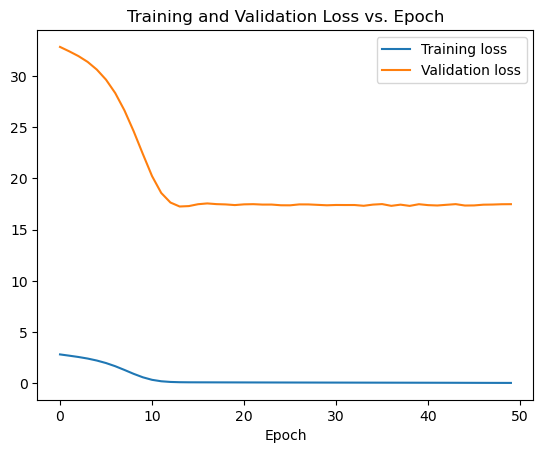

In [338]:
x_dimension = 8
n_datapoints = 100
X = np.random.random([n_datapoints, x_dimension])
X_val = np.random.random([n_datapoints, x_dimension])

A = np.random.rand(x_dimension, 3)
A_val = A + 1**np.random.random([x_dimension, 3]) # slightly different A for validation

Y = X@A + 0.1*np.random.random([n_datapoints, 1]) # noisy linear generation of data
Y_val = X@A_val + 0.1*np.random.random([n_datapoints, 1]) # noisy linear generation of data

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

model = MLP([x_dimension, 10, 20, 3])
loss_fn = nn.MSELoss()
supervised_learning(X, Y, X_val, Y_val, model, 50, 10, loss_fn)

Apply supervised learning to map between our X and Y

/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_76059/1072619658.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_76059/1072619658.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_76059/1072619658.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation, dtype=torch.

Finished epoch 0, latest loss 0.2844472825527191, validation loss 0.4743393063545227
Finished epoch 1, latest loss 0.14544923603534698, validation loss 0.3088584542274475
Finished epoch 2, latest loss 0.13629285991191864, validation loss 0.2973094880580902
Finished epoch 3, latest loss 0.13248471915721893, validation loss 0.28775492310523987
Finished epoch 4, latest loss 0.13065707683563232, validation loss 0.2837589383125305
Finished epoch 5, latest loss 0.1272616982460022, validation loss 0.2817900776863098
Finished epoch 6, latest loss 0.12532071769237518, validation loss 0.27866533398628235
Finished epoch 7, latest loss 0.12375862896442413, validation loss 0.28577691316604614
Finished epoch 8, latest loss 0.12173750251531601, validation loss 0.27880915999412537
Finished epoch 9, latest loss 0.1187879890203476, validation loss 0.28062903881073
Finished epoch 10, latest loss 0.1170787438750267, validation loss 0.28183674812316895
Finished epoch 11, latest loss 0.11702054738998413, va

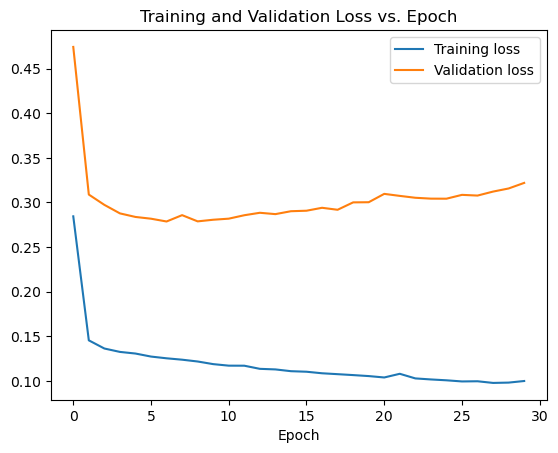

In [375]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
Y_validation = torch.tensor(Y_validation, dtype=torch.float32)

model = MLP([X_train.shape[1], 32, 32, Y_train.shape[1]])
supervised_learning(X_train, Y_train, X_validation, Y_validation, model, 30, 64, nn.MSELoss(), lr=0.001)

(-5075.730586510228, 77231.81432281245, -3902.8748540090473, 75987.47875233678)

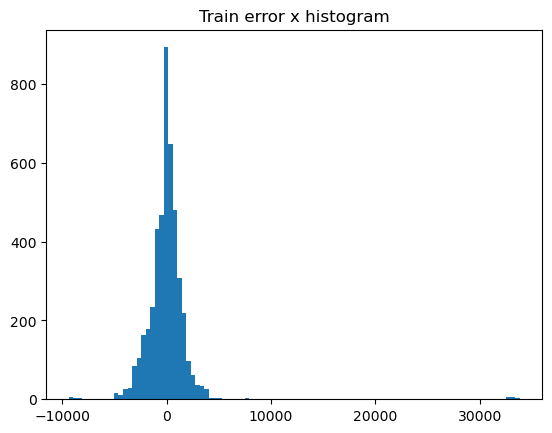

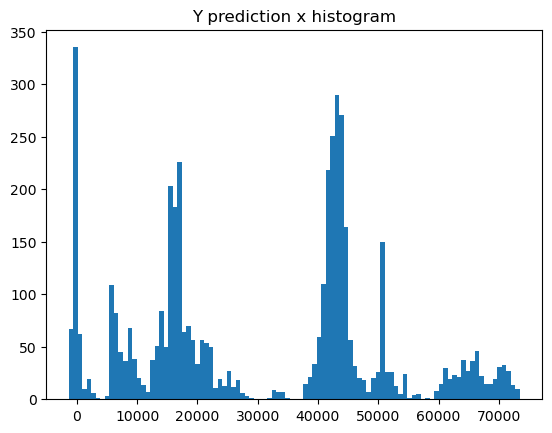

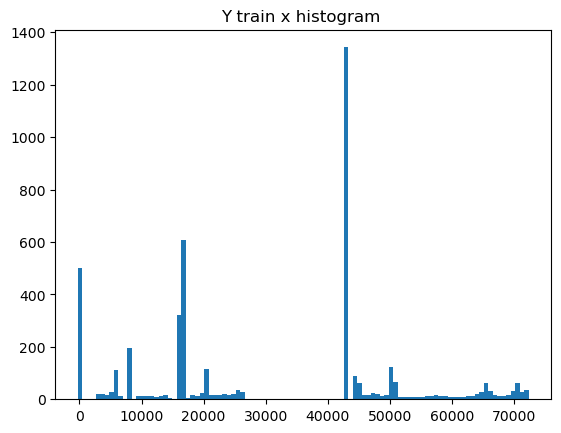

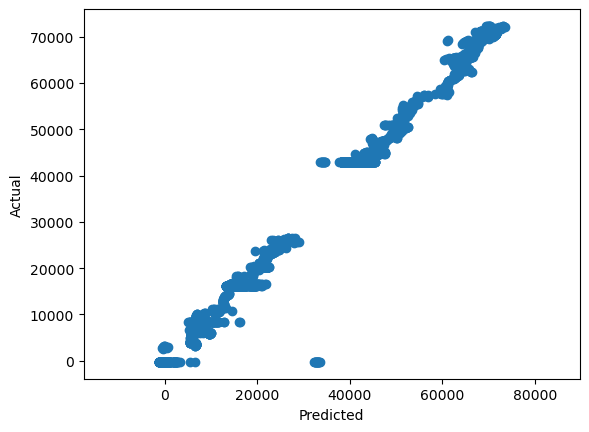

In [376]:
Y_pred = model(X_train).detach().numpy()
unnormalized_Y_pred = unnormalize_matrix(Y_pred, X_train_mean[0:4], X_train_std[0:4])
unnormalized_Y_train = unnormalize_matrix(Y_train.detach().numpy(), X_train_mean[0:4], X_train_std[0:4])

unnormalized_train_errors = unnormalized_Y_pred - unnormalized_Y_train

# histogram of train errors in the first index
plt.figure()
plt.hist(unnormalized_train_errors[:, 0], bins=100)
plt.title("Train error x histogram")

plt.figure()
plt.hist(unnormalized_Y_pred[:, 0], bins=100)
plt.title("Y prediction x histogram")

plt.figure()
plt.hist(unnormalized_Y_train[:, 0], bins=100)
plt.title("Y train x histogram ")

plt.figure()
plt.plot(unnormalized_Y_pred[:, 0], unnormalized_Y_train[:, 0], 'o')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.axis('equal')

In [341]:
Y_pred[0, :] # - Y_train[0, :].detach().numpy()


array([ 2.0367494,  1.3340379,  0.8305191, -0.9669732], dtype=float32)

In [342]:
X_train.shape

torch.Size([4590, 28])

In [373]:
def plot_line(line, index):
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], color='black', linewidth=1)
    # write the number i next to each line
    plt.text((x1+x2)/2, (y1+y2)/2, str(index), fontsize=10, color='red')

def visualize_map(centerlines):
    for i, line in enumerate(centerlines):
        plot_line(line, i+1)

def visualize_prediction(state_matrix, model, X_mean, X_stdev, Y_mean, Y_std, n_steps_ahead, sim_time=20):
    xs_groundtruth = state_matrix[:, 0]
    ys_groundtruth = state_matrix[:, 1]

    simulation_time = 60
    dt = 1/15
    n_steps = int(sim_time / dt / n_steps_ahead)
    ego_states = np.zeros((n_steps, 4))

    print("n steps: ", n_steps)


    cur_ego_state = state_matrix[0, 0:4]
    for i in range(n_steps):
        # Record the ego state that you're at
        ego_states[i, :] = cur_ego_state

        # Start with the ground truth state 
        input_features = state_matrix[[n_steps_ahead*i], :] # list on [n_steps_ahead * i] to preserve dimensionality

        # Replace the prediction for the current x, y, angle, and speed 
        input_features[0, 0:4] = cur_ego_state
        # Normalize your input features, cast to a torch tensor, then pass through the model
        normalized_input = torch.tensor(normalize_matrix(input_features, X_mean, X_stdev), dtype=torch.float32)
        ego_next_normalized = model(normalized_input)
        ego_next_normalized = ego_next_normalized.detach().numpy()

        # unnormalize the output and then update your current ego state
        ego_next = unnormalize_matrix(ego_next_normalized, Y_mean,  Y_std)
        cur_ego_state = ego_next
    
    plt.figure()
    #visualize_map(centerlines)
    plt.plot(xs_groundtruth, ys_groundtruth, label='Ground truth trajectory')
    plt.plot(ego_states[:, 0], ego_states[:, 1], label='Predicted trajectory', color='r', linestyle='dashed')
    plt.axis('equal')
    plt.legend()




n steps:  60
n steps:  10


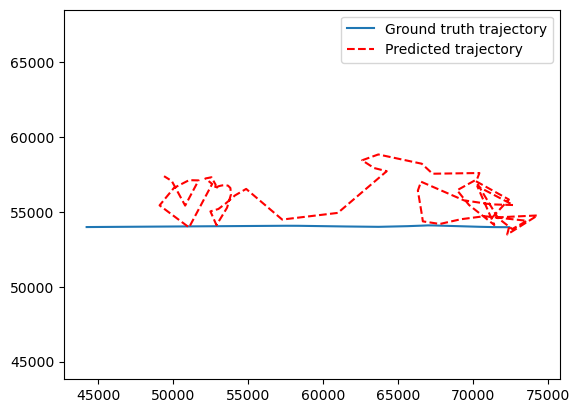

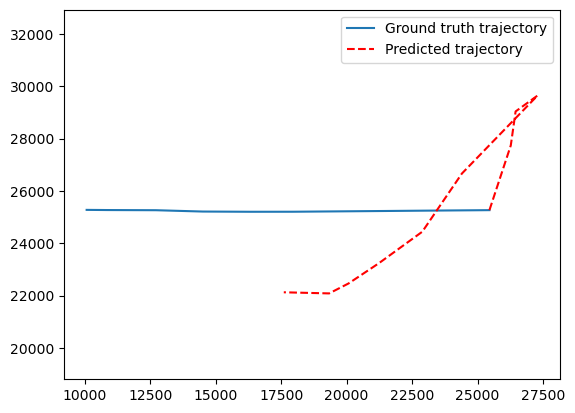

In [374]:
first_train = train_demonstrations[0][0]
first_validation = validation_demonstrations[0][0]
visualize_prediction(first_train, model, X_train_mean, X_train_std, X_train_mean[0:4], X_train_std[0:4], n_steps_ahead=n_steps_ahead, sim_time=60)
visualize_prediction(first_validation, model, X_train_mean, X_train_std, X_train_mean[0:4], X_train_std[0:4], n_steps_ahead=n_steps_ahead, sim_time=10)

In [345]:
validation_demonstrations[0][0].shape

(300, 28)